In [57]:
import pycbc.noise
from pycbc.noise import noise_from_psd
import pycbc.psd
import pylab as plt
import csv
from pycbc.waveform import get_td_waveform
import random
import numpy as np
from pycbc.types import TimeSeries, Array
import concurrent.futures

In [58]:
T = 4
flow = 30.0
delta_f = 1.0 / T
flen = int(2048 / delta_f) + 1
delta_t = 1.0 / 4096
tsamples = int(T / delta_t)

scale = 1100

In [59]:
# PSD
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
noisesamples = int(4 / delta_t)

In [60]:
import os
import pandas as pd

if os.path.exists(
    "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data.csv"
):

    num_lines = pd.read_csv(
        "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data.csv"
    ).shape[0]

    print(num_lines)
else:
    with open(
        "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data.csv",
        "w",
        newline="",
    ) as file:
        writer = csv.writer(file)
        writer.writerow(["M1", "M2", "Time", "SNR", "ChirpMass", "Path"])

    num_lines = 0

28842


In [61]:
class StratifiedRandomGenerator:
    def __init__(self, min_value, max_value, num_bins):
        self.min_value = min_value
        self.max_value = max_value
        self.num_bins = num_bins
        self.bin_width = (max_value - min_value) / num_bins
        self.bin_counts = np.zeros(num_bins)

    def generate(self):
        min_count = np.min(self.bin_counts)
        candidate_bins = np.where(self.bin_counts == min_count)[0]
        chosen_bin = random.choice(candidate_bins)
        bin_start = self.min_value + chosen_bin * self.bin_width
        value = random.uniform(bin_start, bin_start + self.bin_width)
        self.bin_counts[chosen_bin] += 1
        return value


# Instantiate generators
m1_generator = StratifiedRandomGenerator(10, 30, num_bins=100)
m2_generator = StratifiedRandomGenerator(10, 30, num_bins=100)

In [62]:
def get_shifted_wvfrm(shift_percent):
    # WVFRM generation
    m1 = int(m1_generator.generate())
    m2 = int(m2_generator.generate())

    print(m1, m2)
    hp, hc = get_td_waveform(
        approximant="IMRPhenomT",
        mass1=m1,
        mass2=m2,
        delta_t=1.0 / 4096,
        f_lower=30,
    )
    hp.resize(16384)
    hc.resize(16384)

    # Shift the waveform
    total_length = len(hp.sample_times)
    shift_index = int(shift_percent * total_length)
    shifted_data = np.zeros_like(hp.data)
    shift_amount = min(len(hp.data), total_length - shift_index)
    shifted_data[shift_index : shift_index + shift_amount] = hp.data[:shift_amount]
    ts = TimeSeries(shifted_data, delta_t=delta_t)
    return ts, m1, m2, hp


def get_noise(seed):
    noise = noise_from_psd(tsamples, delta_t, psd, seed=seed)
    return noise

In [63]:
def get_time_and_snr(template, signal):

    snr = pycbc.filter.matched_filter(
        template, signal, psd=psd, low_frequency_cutoff=flow
    )

    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    time = snr.sample_times[peak]

    return time, snrp

In [64]:
def path(index):
    return f"Continous_Check/Data/signal_{index+num_lines}.png"


def append_csv(csv_parameters_batch, index):

    def format_value(value):
        if isinstance(value, float):
            return f"{value:.3f}"
        return value

    with open(
        "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data.csv",
        "a",
        newline="",
    ) as file:
        writer = csv.writer(file)
        for i, row in enumerate(csv_parameters_batch):
            formatted_row = [format_value(value) for value in row]
            row_with_path = formatted_row + [path(i + index)]
            writer.writerow(row_with_path)


def save_specgram(waveforms, index):
    print("Save spectrogram started")
    for i, waveform in enumerate(waveforms):
        plt.specgram(waveform, Fs=2048)
        plt.axis("off")
        plt.savefig(
            f"/home/arush/GW_Project_1/Data_Generation/{path(i+index)}",
            bbox_inches="tight",
            pad_inches=0,
        )
        plt.close()
        print("Spectrogram saved", (i + index))

In [65]:
def save_func(csv_parameters_batch, waveforms, index):
    print("save func executed")

    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(append_csv, csv_parameters_batch, index),
            executor.submit(save_specgram, waveforms, index),
        ]

        for future in concurrent.futures.as_completed(futures):
            print(future.result())

In [66]:
l = 0
batch_size = 25
batch_data = []
waveforms = []

In [67]:
def process_waveform(l):
    global m2_process_wvfrm

    random_shift_var = random.uniform(0, 0.7)
    waveform, m1, m2, template = get_shifted_wvfrm(random_shift_var)
    noise = get_noise(l)
    signal = (waveform / scale) + noise

    time, snr = get_time_and_snr(template=template, signal=signal)
    chirp_m = ((m1 * m2) ** (3 / 5)) / ((m1 + m2) ** (1 / 5))
    csv_append = [m1, m2, time, snr, chirp_m]

    return csv_append, signal

In [68]:
def main():
    batch_size = 50
    total_iterations = 2000
    for start in range(0, total_iterations, batch_size):
        print("start: ", start)
        batch_data = []
        m2_values = []
        waveforms = []
        end = min(start + batch_size, total_iterations)
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [executor.submit(process_waveform, l) for l in range(start, end)]
            for future in concurrent.futures.as_completed(futures):
                csv_append, waveform = future.result()
                batch_data.append(csv_append)
                waveforms.append(waveform)

                m2_values.append(csv_append[1])  # Collect M2 values
        save_func(batch_data, waveforms, start)

In [69]:
main()

start:  0
15121626152810132715241222    21        2717 151124 242926121528
17191710
  

15








1129


25 2022
14 2122  20
23
27 29
1813 
29
26  222519
 17

17 15
29 19
12 20
29 24
19 27
17 11
14 29
12 19
25 2927
 29
191311  2726
10 
 2829 
13 2012
18
28
21  1423
28
 27
28 17
11 15
29 25
23 21
20 17 
1611
save func executed
Save spectrogram started
None
Spectrogram saved 0
Spectrogram saved 1
Spectrogram saved 2
Spectrogram saved 3
Spectrogram saved 4
Spectrogram saved 5
Spectrogram saved 6
Spectrogram saved 7
Spectrogram saved 8
Spectrogram saved 9
Spectrogram saved 10
Spectrogram saved 11
Spectrogram saved 12
Spectrogram saved 13
Spectrogram saved 14
Spectrogram saved 15
Spectrogram saved 16
Spectrogram saved 17
Spectrogram saved 18
Spectrogram saved 19
Spectrogram saved 20
Spectrogram saved 21
Spectrogram saved 22
Spectrogram saved 23
Spectrogram saved 24
Spectrogram saved 25
Spectrogram saved 26
Spectrogram saved 27
Spectrogram saved 28
Spectrogram saved 29
Spectrogram saved 30


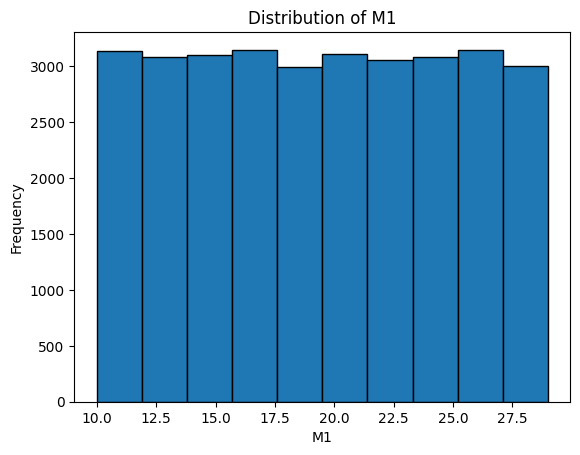

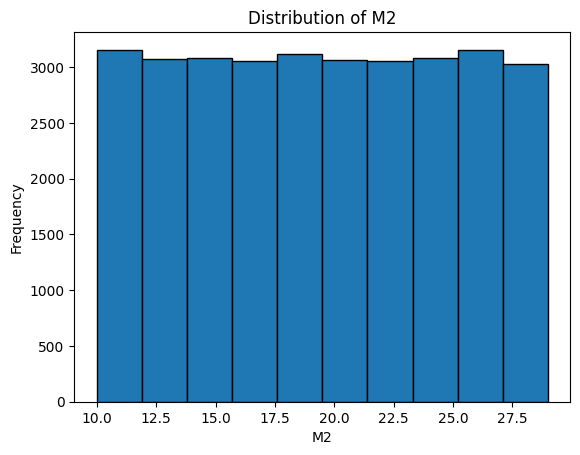

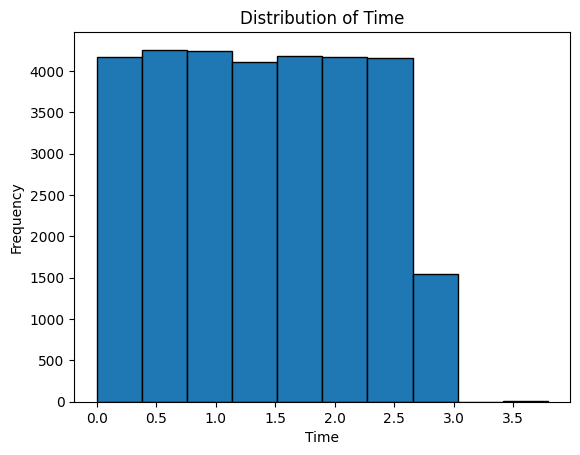

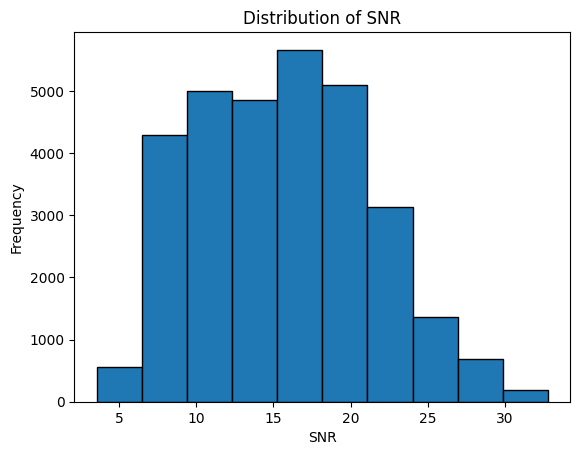

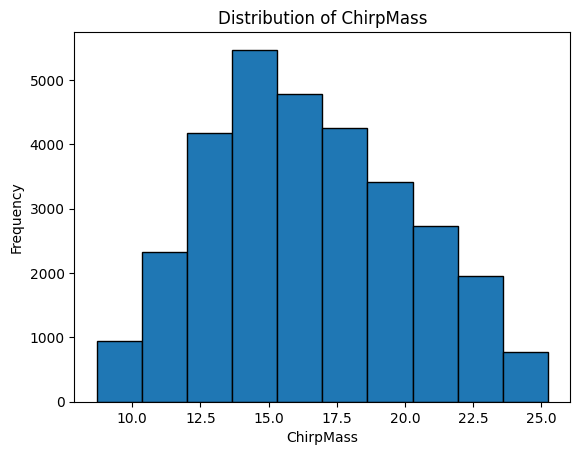

In [70]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_histogram_from_csv(file_path, column_name, bins=10):

    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path, usecols=[column_name])

    # Check if the specified column exists
    if column_name not in data.columns:
        print(f"Column '{column_name}' does not exist in the CSV file.")
        return

    # print(data)

    # Create a histogram
    plt.hist(data, bins=bins, edgecolor="black")

    # Add titles and labels
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")

    # Show the plot
    plt.show()


# Example usage
file_path = "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data.csv"


plot_histogram_from_csv(file_path, "M1")
plot_histogram_from_csv(file_path, "M2")
plot_histogram_from_csv(file_path, "Time")
plot_histogram_from_csv(file_path, "SNR")
plot_histogram_from_csv(file_path, "ChirpMass")

plt.show()